In [1]:
%cd ..


/run/media/nazif/2F946E411BA61D49/thesis


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
import seaborn as sns
pd.set_option('display.max_columns', None)


In [3]:
class DropRowsCache:
    total_dropped = 0
    
    @classmethod
    def drop_rows_and_report(cls, df, condition):
        filtered_df = df.loc[condition]
        num_dropped = filtered_df.shape[0]
        cls.total_dropped += num_dropped
        df_dropped = df.drop(filtered_df.index)
        
        print(f"Number of dropped rows: {num_dropped}")
        print(f"Total number of dropped rows: {cls.total_dropped}")
        
        return df_dropped



In [4]:
df = pd.read_csv("results/1_generate_data.csv")

df.head()

,mrna_start,mrna_end,pred_energy,mirna_start,mirna_end,mirna_dot_bracket_5to3,id,clash_mrna_start,clash_mrna_end,true_seed_type,true_num_basepairs,true_seed_basepairs,true_energy,mirna_sequence,mirna_accession,enst,ensg,alignment_string,pred_num_basepairs,pred_seed_basepairs,bp_difference,seed_bp_difference,mre_start,mre_end,full_mrna_seq,mre_region
0,23,46,-27.7,1,21,)))))))))))))))))))).,0727A-1038930_1,1791,1890,noncanonical_seed,20,6,-25.1,TGAGGTAGTAGGTTGTATAGTT,MIMAT0000062,ENST00000340828,ENSG00000113328,1111111111111111111100,20,6,0,0,23,44,ATTTGTATCTACGATAAAAATTTTTATACAGAACCTACTGCCTCAA...,TTTATACAGAACCTACTGCCTC
1,12,31,-26.2,1,19,))))))))).)))))))).,L1HS-1112536_1,3857,3928,9-mer,17,6,-24.4,TGAGGTAGTAGGTTGTATAGTT,MIMAT0000062,ENST00000343455,ENSG00000100697,1111111110111111110000,17,6,0,0,12,33,CAGGAAATACCCGTGCAACCAACTACCTCATATTCCATTCAGAATT...,CGTGCAACCAACTACCTCATAT
2,4,25,-23.6,1,22,.)))))).))))))))))))).,L2HS-818542_2,2385,2434,noncanonical_seed,19,6,-22.2,TGAGGTAGTAGGTTGTATAGTT,MIMAT0000062,ENST00000436639,ENSG00000080546,0111111011111111111110,19,6,0,0,4,25,ACCCGCTATATGACCTGATGCCTTTCCTTCATTAAAGATGATTCTG...,CGCTATATGACCTGATGCCTTT
3,4,25,-23.8,1,22,)))))))...)))))))))))),L2HS-1161339_2,6570,6623,noncanonical_seed,18,6,-22.1,TGAGGTAGTAGGTTGTATAGTT,MIMAT0000062,ENST00000282516,ENSG00000164190,1111111000111111111111,19,6,1,0,4,25,CAATGACTATGCAACCATACCTTACCACTAAATGTAGTACGCAAAA...,TGACTATGCAACCATACCTTAC
4,3,25,-24.0,1,22,))))))))))))))...)))).,L2-407944_2,1164,1208,noncanonical_seed,18,6,-21.9,TGAGGTAGTAGGTTGTATAGTT,MIMAT0000062,ENST00000340139,ENSG00000138785,1111111111111100011110,18,6,0,0,3,24,AATACTGGGAAACCTGCTACTTCGTCAGCTAACCAGAAACCTGTG,TACTGGGAAACCTGCTACTTCG


In [5]:
# initiating drop rows method with cache
cache = DropRowsCache()

In [6]:
# dropping rows with low structural stability (energy close to 0)
cond_energy = df['true_energy'] > -5
df = cache.drop_rows_and_report(df, cond_energy)

# dropping rows where true seed base pairs doesn't match true seed type
cond_6mer = (df["true_seed_basepairs"] <= 4) & (df["true_seed_type"] == "6-mer")
cond_7mer = (df["true_seed_basepairs"] <= 4) & (df["true_seed_type"] == "7-mer")
cond_8mer = (df["true_seed_basepairs"] <= 4) & (df["true_seed_type"] == "8-mer")

df = cache.drop_rows_and_report(df, cond_6mer)
df = cache.drop_rows_and_report(df, cond_7mer)
df = cache.drop_rows_and_report(df, cond_8mer)


Number of dropped rows: 87
Total number of dropped rows: 87
Number of dropped rows: 119
Total number of dropped rows: 206
Number of dropped rows: 86
Total number of dropped rows: 292
Number of dropped rows: 33
Total number of dropped rows: 325


In [7]:
# these operations were added after final presentation

# dropping rows where true number of bp is lower than 6
cond_true_numbp = df['true_num_basepairs'] < 6
df = cache.drop_rows_and_report(df, cond_true_numbp)

# dropping rows where predicted number of bp is lower than 6
cond_pred_numbp = df['pred_num_basepairs'] < 6
df = cache.drop_rows_and_report(df, cond_pred_numbp)

# # dropping rows where our seed bp predictions are way lower than true ones
# cond_seedbp = df['seed_bp_difference'] < -2
# df = cache.drop_rows_and_report(df, cond_seedbp)

Number of dropped rows: 49
Total number of dropped rows: 374
Number of dropped rows: 18
Total number of dropped rows: 392


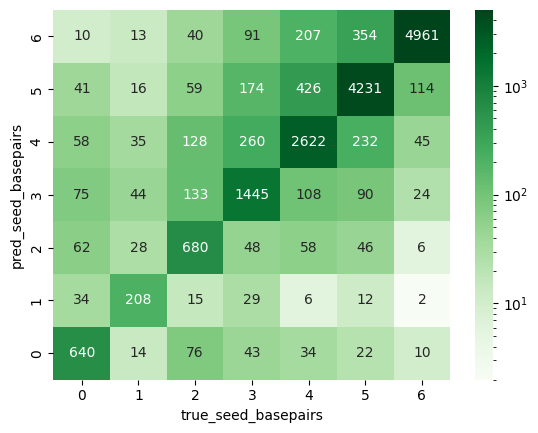

In [8]:

asd = df[["pred_seed_basepairs", "true_seed_basepairs"]]

pivot_table = asd.pivot_table(index='pred_seed_basepairs', columns='true_seed_basepairs', aggfunc=len, fill_value=0)
pivot_table = pivot_table[::-1]

# Create a logarithmic color scaling norm
norm = mcolors.LogNorm(vmin=pivot_table.values.min(), vmax=pivot_table.values.max())

sns.heatmap(pivot_table, annot=True, fmt='d', cmap='Greens', norm=norm)
plt.show()

In [10]:
# export to csv
cols_to_keep = ['mrna_start', 'mrna_end', 'pred_energy', 'mirna_start', 'mirna_end',
                'mirna_dot_bracket_5to3', 'mirna_sequence', "mirna_accession", "mre_region", "enst"]

positive_df_results = df[cols_to_keep]
positive_df_results.to_csv("results/2_positive_data.csv", index=False)